## Train Script of Seq2Seq RNN model

In [1]:
import torch
from torchtext import data
from torchtext import datasets
import torch.nn.functional as F

In [2]:
import random
import tqdm.auto
import unicodedata
import re

In [3]:
from models.decoder import DecoderRNN
from models.encoder import EncoderRNN

In [4]:
from utils import *

--------------------

In [5]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 35

In [6]:
device = torch.device('cuda:3')

In [7]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH, device=device):
    encoder_hidden = encoder.initHidden(device)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0 
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
            #topv, topi = decoder_output.topk(1)
            #decoder_input = topi.squeeze().detach()
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length   

In [8]:
def train_epoch(data_train, epoch, device):
    print(f"\nTrain Epoch: {epoch}.")
    loss_train, steps = 0.0, 0
    for pair in tqdm.auto.tqdm(data_train):
        input_tensor, target_tensor = tensorFromPair(input_lang, output_lang, pair, device)
        loss = train(input_tensor, target_tensor, encoder, 
                     decoder, encoder_optimizer, decoder_optimizer, 
                     criterion)
        loss_train += loss
        steps += 1
    loss_train_avg = loss_train / steps
    template_print = f"Epoch(train): {epoch} Loss_train: {loss_train_avg:.3f}."
    print(template_print)
    return loss_train, loss_train_avg

In [9]:
def evaluation(encoder, decoder, sentence, sentence_target, max_length=MAX_LENGTH, device=device):
    with torch.no_grad():
        sentence_list = list(jieba.cut(sentence_target, cut_all=False))
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden(device=device)
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], 
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        max_n = min(4, len(decoded_words[:-1]), len(sentence_list))
        if max_n == 0:
            bleu = 0
        else:
            weights = (1.0 / max_n, ) * max_n
            bleu = data.metrics.bleu_score([decoded_words[:-1]], [[sentence_list]], max_n=max_n, weights=weights)
        return decoded_words, bleu

In [26]:
def evaluate_bleu(encoder, decoder, data_valid):
    bleu_acm = 0.0
    num_valid = len(data_valid)
    for pair in data_valid:
        output_words, bleu_i = evaluation(encoder, decoder, pair[0], pair[1])
        bleu_acm += bleu_i
    bleu_avg = bleu_acm / num_valid
    print(f"avg bleu is: {bleu_avg:.3f}.")
    return bleu_avg

In [27]:
def evaluateRandomly(encoder, decoder, data_valid, n=10):
    bleu_acm = 0.0
    for i in range(n):
        pair = random.choice(data_valid)
        print('>', pair[0])
        print('=', pair[1])
        output_words, bleu_i = evaluation(encoder, decoder, pair[0], pair[1])
        bleu_acm += bleu_i
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
    bleu_avg = bleu_acm / n
    print(f"avg bleu is: {bleu_avg:.3f}.")

----------------------
### Data Preparing

In [12]:
input_lang, output_lang, pairs = prepareDataMand('en', 'zh')

Reading Lines...


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Read 29458 sentence pairs
Counting words...


Loading model cost 0.590 seconds.
Prefix dict has been built successfully.


Counted words:
en 7367
zh 16261


In [13]:
num_samples = len(pairs)
num_valid = num_samples // 10

In [14]:
random.shuffle(pairs)

In [15]:
pairs_training, pairs_valid = pairs[:-num_valid], pairs[-num_valid:]

In [16]:
teacher_forcing_ratio = 0.5

In [17]:
hidden_size = 256
input_size = input_lang.n_words
output_size = output_lang.n_words

In [18]:
encoder = EncoderRNN(input_size, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_size).to(device)

In [19]:
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=1e-3)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=1e-3)

In [20]:
criterion = torch.nn.NLLLoss()

In [21]:
num_epochs = 50

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [ ]:
loss_train_avg_list, bleu_score_list = [], []
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1);
ax2 = fig.add_subplot(1, 2, 2);
ax1.set_xlabel('test');
for i in range(1, num_epochs+1):
    loss_train, loss_train_avg = train_epoch(pairs_training, i, device)
    bleu_avg_i = evaluate_bleu(encoder, decoder, pairs_valid)
    loss_train_avg_list.append(loss_train_avg)
    bleu_score_list.append(bleu_avg_i)
    x1 = np.arange(0, i);
    
    x2 = np.arange(0, i);
    
    ax1.set_xlim(0, i)
    ax2.set_xlim(0, i)
    
    ax1.cla()
    ax1.plot(x1, loss_train_avg_list)
    
    ax2.cla()
    ax2.plot(x2, bleu_score_list)
    
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.8)


Train Epoch: 19.


  0%|          | 0/26513 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

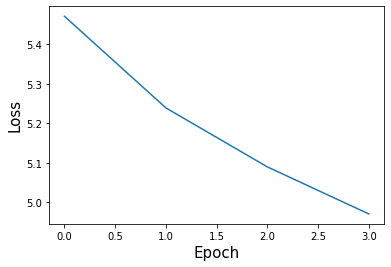

In [24]:
plt.plot(x1, loss_train_avg_list)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)

Text(0, 0.5, 'Bleu')

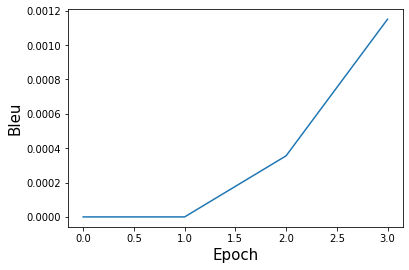

In [25]:
plt.plot(x1, bleu_score_list)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Bleu', fontsize=15)